In [32]:
# 导入库
import pandas as pd
import numpy as np
import json
import sys
import scipy.stats as st
import statsmodels.formula.api as smf # 分位数回归所需
import talib
from tqdm import tqdm
from jqdata import *
import pickle
# 画图
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
pd.plotting.register_matplotlib_converters()
import seaborn as sns
%matplotlib inline
# 设置字体 用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']

# 用来正常显示负号
plt.rcParams['axes.unicode_minus'] = False

# 图表主题
plt.style.use('seaborn')

# 原始公式的解读

原始的格雷厄姆成长股内在价值公式可表述为:
$$Value=E*(8.5+2*R)$$
其中：E表示每股收益(EPS),决定了公司内在价值的基准;R表示预期收益增长率，体现了公司的未来盈利能力;数值8.5被格雷厄姆认为式一家公司为0的公司的合理PE,故(8.5+2*R)可以被视为预期收益率增长率为R的公司的合理市盈率。

但这个8.5在A股市场有待商榷，不过我们为了方便对比，先沿用这个数值。

# 改进格雷厄姆成长股内在价值公式

在上面基础上提出两个改进因子。一个因子式考虑了格雷厄姆著名的“安全边际”原则，称为安全因子；另一个因子考虑利率对股价的影响，称为利率调整因子。

$$Value=E*(8.5+2*R)*SF*IF$$

安全因子(SF)为0到1之间的数值，表示对股票内在价值的折价。格雷厄姆支持，“安全边际就是价格针对价值大打折扣”

利率调整因子(IF)的公式为：

IF=历史平均3年期中债国债到期收益率/当期3年期中债国债到期收益率

利率调整因子所表达的投资逻辑:低息例好股市，股票内在价值溢价；高息压低股市,股票内在价值折价。

在量化选股时，我们将股票内在价值在1到1.2之间的股票进入组合。设置1.2的上限阀值是出于两个目的：一是控制筛选出的 股票数量，便于不同策略的对比；二是出于对公式有效性的考虑——当股票内在价值与股价偏离非常非常大时，必然存在公式以外的因子起作用，此时单纯用公式选股无意义。

|指标|含义|
|--|--|
|当期利润|每股收益(TTM)|
|预期年增长率|每股收益增长率|
|AAA债券收益率|3年期中债国债到期收益率|
|安全因子|0.4|

In [33]:
# 3年期国债获取:https://cn.investing.com/rates-bonds/china-3-year-bond-yield-historical-data
yield_data = pd.read_csv('中国三年期国债收益率历史数据.csv')
yield_data['日期'] = pd.to_datetime(yield_data['日期'],format='%Y-%m-%d')
yield_data.set_index('日期',inplace=True)
yield_data.sort_index(inplace=True)

In [34]:
yield_data.head()

,收盘,开盘,高,低,涨跌幅
日期,,,,,
2006-06-02,2.24,2.24,2.24,2.24,-10.83%
2006-06-05,2.30,2.30,2.30,2.30,2.68%
2006-06-06,2.30,2.30,2.30,2.30,0.00%
2006-06-07,2.33,2.33,2.33,2.33,1.30%
2006-06-08,2.38,2.38,2.38,2.38,2.15%


In [35]:
# 周期频率获取

# 获取指定周期的日期列表 'W、M、Q'
def get_period_date(peroid, start_date, end_date):
    # 设定转换周期period_type  转换为周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
    stock_data = get_price(
        '000001.XSHE', start_date, end_date, 'daily', fields=['close'])
    # 记录每个周期中最后一个交易日
    stock_data['date'] = stock_data.index
    # 进行转换，周线的每个变量都等于那一周中最后一个交易日的变量值
    period_stock_data = stock_data.resample(peroid).last()
    date = period_stock_data['date']
    pydate_array = date.dt.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(
        pydate_array)
    date_only_series = pd.Series(date_only_array)
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    start_date = start_date - datetime.timedelta(days=1)
    start_date = start_date.strftime("%Y-%m-%d")
    date_list = date_only_series.values.tolist()
    date_list.insert(0, start_date)
    return date_list


# 股票池筛选

# 去除上市距beginDate不足 3 个月的股票
def delect_stop(stocks, beginDate, n=30 * 3):
    stockList = []
    beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
    for stock in stocks:
        start_date = get_security_info(stock).start_date
        if start_date < (beginDate - datetime.timedelta(days=n)).date():
            stockList.append(stock)
    return stockList


# 获取股票池
def get_stock_A(begin_date):
    begin_date = str(begin_date)
    stockList = get_index_stocks('000002.XSHG', begin_date) + get_index_stocks(
        '399107.XSHE', begin_date)
    # 剔除ST股
    st_data = get_extras('is_st', stockList, count=1, end_date=begin_date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    # 剔除停牌、新股及退市股票
    stockList = delect_stop(stockList, begin_date)
    return stockList

# 数据获取
def query_data(stock_pool, tradeDate):

    # pubDate 公布日
    # statDate 审计截止日
    fields = [
        indicator.eps,
    ]

    # 查询财务信息
    ## 过去12个季度数据
    fundamental_df = get_history_fundamentals(
        stock_pool,
        fields=fields,
        watch_date=tradeDate,
        count=12,
        interval='1q')

    valuation_df = get_valuation(
        stock_pool,
        end_date=tradeDate,
        fields=['pe_ratio'],
        count=12)

    return fundamental_df, valuation_df  # data为字典

In [36]:
# 设置回测区间
start_date,end_date = '2010-01-01','2023-05-23'

# 获取回测时间段
date_range = get_period_date('M', start_date, end_date)
yield_bt = yield_data.reindex(pd.to_datetime(get_period_date('M', start_date, end_date))).fillna(method='ffill')
date_range = tqdm(date_range,position=0,leave=True)
temp = {} # 中间过程
temp1 = {} 
for trade_date in date_range:
    
    # 获取股票池
    stock_pool = get_stock_A(trade_date)
    # 获取数据
    fundamental_df, valuation_df = query_data(stock_pool, trade_date)
    price_df = get_price(stock_pool,end_date=trade_date,count=1,fields='close',panel=False).set_index('code')
    # 数据计算准备
    eps_pivot = pd.pivot_table(fundamental_df,index='statDate',columns='code',values='eps')
    R = eps_pivot.pct_change().mean() # R is series,index is code
    E = eps_pivot.iloc[-1] # E like R
    
    IF = yield_bt.loc[:trade_date,'收盘'].mean()/yield_bt.loc[trade_date,'收盘']
    SF = 0.4
    
    # 价值公式
    ## E∗(8.5+2∗R)∗SF∗IF
    VALUE = E*(8.5+2*R)*SF*IF
    pe_mean = valuation_df['pe_ratio'].mean()
    #VALUE1 = E*(pe_mean+2*R)*SF*IF
    df = pd.concat([VALUE,price_df['close']],axis=1,sort=True)
    #df1 = pd.concat([VALUE1,price_df['close']],axis=1,sort=True)
    temp[trade_date] = df
    #temp1[trade_date] = df1
    
    

100%|██████████| 162/162 [04:54<00:00,  2.50s/it]


In [37]:
yield_bt.head()

,收盘,开盘,高,低,涨跌幅
2009-12-31,2.400,2.400,2.400,2.400,0.00%
2010-01-29,2.400,2.400,2.400,2.400,0.00%
2010-02-26,2.450,2.450,2.450,2.450,0.00%
2010-03-31,2.240,2.240,2.240,2.240,-2.18%
2010-04-30,2.443,2.443,2.443,2.443,6.22%


In [38]:
factor = pd.concat(temp.values(),keys=temp.keys())
factor.columns = ['factor','close']
factor.index.names = ['date','code']

In [39]:
factor.head()

factor  close
date       code                        
2009-12-31 000001.XSHE  1.366333   7.69
           000002.XSHE  0.173178   6.93
           000005.XSHE -0.043495   6.02
           000006.XSHE      -inf   3.19
           000009.XSHE  0.104141   4.76

In [40]:
# 因子筛选
factor['factor'] = np.where(np.isinf(factor['factor']),0,factor['factor'])
factor['next_ret'] = factor.groupby(level='code')['close'].transform(lambda x:x.pct_change().shift(-1))
def select_stock(df):
    return df.query('factor>=1 & factor<=1.2')

target_df = factor.groupby(level=0,group_keys=False).apply(select_stock)

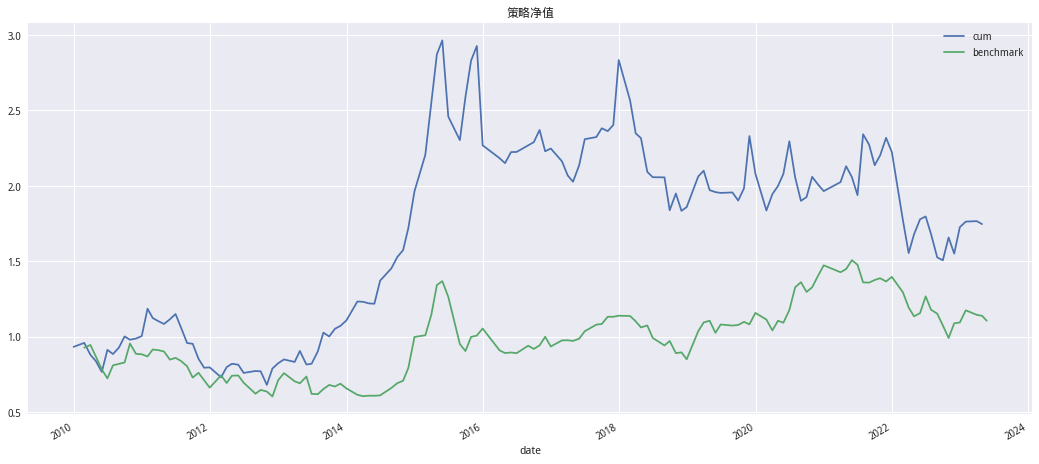

In [41]:
# 策略净值
ret = target_df.groupby('date')['next_ret'].mean()
cum = (1+ret).cumprod()

benchmark = get_price('000300.XSHG',
                      start_date=start_date,
                      end_date=end_date,
                      fields='close',
                      panel=False)
plt.rcParams['font.family']='serif' # pd.plot中文
rpt = pd.DataFrame()
rpt['cum'] = cum
rpt.index = pd.to_datetime(cum.index)
rpt['benchmark'] = (1+benchmark['close'].pct_change()).cumprod()
rpt.plot(figsize=(18,8),title='策略净值')

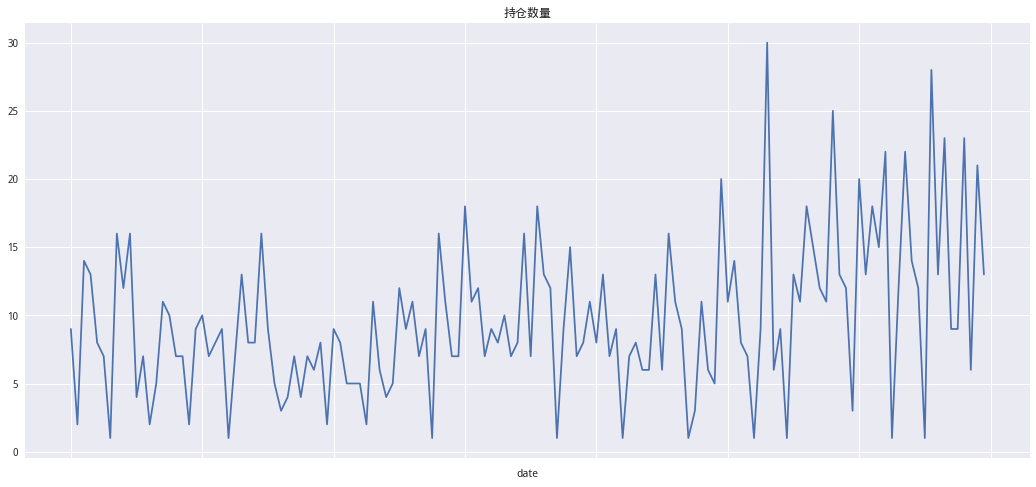

In [42]:
# 持仓数量
stock_num = target_df.groupby(level='date').apply(lambda x:len(x))
stock_num.plot(figsize=(18,8),title='持仓数量')